# Model selection & comparison

_Alex Malz (LINCC@CMU)_
_LSSTC Data Science Fellowship Program #16_

This problem session is a bit of a "choose your own adventure," though all will cover the Bayes factor and some information-theoretic quantities.
You find yourself in a dark, haunted forest and reach a fork in the road.

- You can play it safe and follow Adam Mantz's version of the [lecture](https://github.com/KIPAC/StatisticalMethods/blob/1a8d82d6e54c421fb22f2e891293f220bf257da1/chunks/modelevaluation.ipynb) and [problem set](https://github.com/KIPAC/StatisticalMethods/blob/1a8d82d6e54c421fb22f2e891293f220bf257da1/problems/model_evaluation.ipynb) from a few years ago. It will cover the Bayesian evidence and information criteria (like the AIC, but appropriate for Bayesian statistics) for a simple exponential model.
- You can look at the other notebook here __TODO: link to toyish metrics notebook__ and do those same exercises from Adam's notebook above, but for data that's realistic for an astrophysical problem (Type Ia SNe for constraining cosmological models and parameters).
- You can proceed with this notebook, which uses some real MCMC chains from a real paper, where the "truth" isn't known and there are tough questions of whether each model comparion metric is appropriate given the assumptions that went into the data in hand.

And, just like a "choose your own adventure" novel, you can always try the others later on or switch if you're not having fun.

In [1]:
from chainconsumer import ChainConsumer
import numpy as np
import os

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# These are to make the plots from the paper, which used an older version of Python.
import pylab as mplot
%pylab inline

mplot.rc('xtick', labelsize=16) 
mplot.rc('ytick', labelsize=16) 

Color = ['#404096','#57A3AD','#D92120','#DEA73A']

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Data

Let's take a close look at the procedure of [Chang+18](https://doi.org/10.1093/mnras/sty2902), in which the data from four completed weak lensing surveys were reanalyzed under common assumptions.

We have the MCMC chains resulting from fits to the data of each survey under their published priors and model assumptions as well as under shared priors and the same model assumptions.
The paper originally only published the code necessary to do the sampling __TODO: link the Zenodo__ rather than the MCMC samples themselves, so special thank you to Chihway Chang __TODO: link to Chihway__ for providing these!
Let's isolate the values of $S_{8}$ and $\Omega_{m}$, even though all versions of the analysis fit additional parameters beyond those.

In [3]:
def get_s8(omegam, sigma8):
    return sigma8*np.sqrt(omegam/0.3)

Let's recreate Figure 6 from the paper.
This shows the published results for two of the four surveys, DES and DLS, because the other two, CFHTLenS and KiDS, formatted their chains differently so the files are pretty big for GitHub;
the code for including those is included here so you can try downloading the chains from [CFHTLenS](https://www.dropbox.com/sh/eqown5h00p6lkij/AABNK8exWIEeQF-xS2JvhmNPa?dl=0) and [KiDS](https://www.dropbox.com/sh/1xyksuucgeeup96/AAAUU2QhRJVTven64qFaZzwva?dl=0) yourself to see all four at once.

Text(1, 1.2, 'DES-SV')

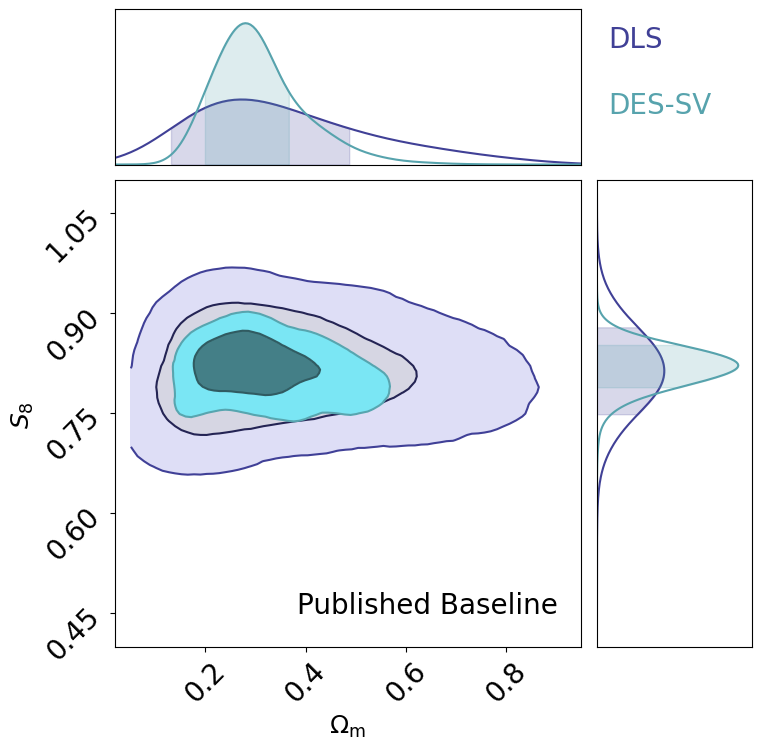

In [8]:
# cfhtlens_paper = 'data/official/CFHTLenS/fiducialrun'#'../old/cfhtlens/paper/fiducialrun'
# kids_paper = 'data/official/KiDS450/kids450dir'#'../old/kids/paper/kids450dir/kids450dir'
des_paper = '/Users/niamhosullivan/Desktop/dsfp2022-main/data/official/DES/dessv_chain_reduced_v2.txt'#'../old/dessv/paper/dessv_chain_reduced_v2.txt'
dls_paper = '/Users/niamhosullivan/Desktop/dsfp2022-main/data/official/DLS/DLS_chain.txt'#'../old/dls/paper/DLS_chain.txt'

data_params = []
weights = []
file_list = [None,#cfhtlens_paper, 
             None,#kids_paper, 
             des_paper, dls_paper]
probs_pub = []

# Om = np.array([])
# s8 = np.array([])
# ww = np.array([])
# for i in range(8):
#     data = np.loadtxt(file_list[0]+'_'+str(i+1)+'.txt')
#     N = len(data)
#     Om = np.concatenate((Om, data[int(N*0.3):,9]), axis=0)
#     s8 = np.concatenate((s8, data[int(N*0.3):,13]), axis=0)
#     ww = np.concatenate((ww, data[int(N*0.3):,0]), axis=0)
# data_params.append([Om, get_s8(Om, s8)])
# weights.append(ww)

# Om = np.array([])
# s8 = np.array([])
# ww = np.array([])
# for i in range(8):
#     data = np.loadtxt(file_list[1]+'_'+str(i+1)+'.txt')
#     N = len(data)
#     Om = np.concatenate((Om, data[int(N*0.3):,10]), axis=0)
#     s8 = np.concatenate((s8, data[int(N*0.3):,14]), axis=0)
#     ww = np.concatenate((ww, data[int(N*0.3):,0]), axis=0)
# data_params.append([Om, get_s8(Om, s8)])
# weights.append(ww)

data = np.loadtxt(file_list[2])
os.system("cat "+file_list[2]+" | tail -3 | head -1 | sed s/'='/' '/|awk '{print $2}'>nsample")
nsample = int(np.loadtxt('nsample'))
weights.append(data[-nsample:,14])
data_params.append([data[-nsample:,0], data[-nsample:,3]*(data[-nsample:,0]/0.3)**0.5]) #12

data = np.loadtxt(file_list[3])
N = len(data)
weights.append(data[:,0])
data_params.append([data[:,2], data[:,3]*(data[:,2]/0.3)**0.5]) 

data_params_published = data_params

c = ChainConsumer()
# c.add_chain(data_params[3], weights=weights[3], name='')
c.add_chain(data_params[0], weights=weights[0], name='', parameters=[r"$\Omega_{\rm m}$", r"$S_{8}$"])
# c.add_chain(data_params[2], weights=weights[2], name='')
c.add_chain(data_params[1], weights=weights[1], name='')

c.configure(colors=Color, label_font_size=18, contour_label_font_size=20, 
            tick_font_size=20, linewidths=[1.5,1.5,1.5,1.5], sigma2d=False, shade=True, 
            kde=1.5, shade_alpha=[0.2,1,0.2,0.7], bar_shade=True, sigmas=[0,1,2])
fig = c.plotter.plot(extents=[(0.02,0.95),(0.4,1.1)])
mplot.text(-27,0.45,'Published Baseline', color='k', fontsize=20)
fig.set_size_inches(4.5 + fig.get_size_inches())  # Resize fig for doco. You don't need this.

mplot.text(1,1.30,'DLS', color=Color[0], fontsize=20)
# mplot.text(1,1.25,'CFHTLenS', color=Color[0], fontsize=20)
mplot.text(1,1.20,'DES-SV', color=Color[1], fontsize=20)
# mplot.text(1,1.15,'KiDS-450', color=Color[0], fontsize=20)

This block of code ingests the chains for the common assumptions case, meaning the same parameters were held constant vs. fit in the MCMC sampling, and the same priors were used.

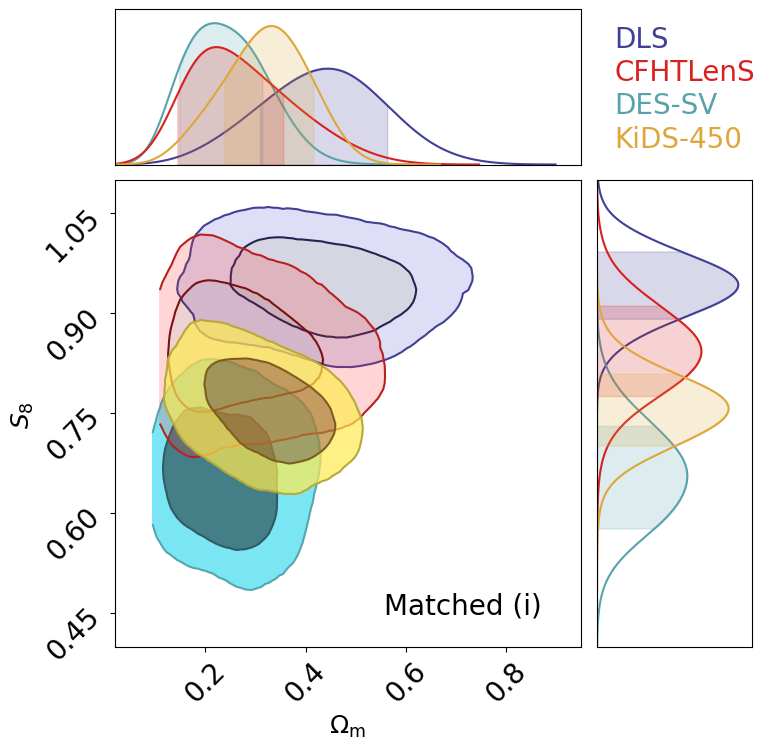

In [9]:
cfhtlens2_g = '/Users/niamhosullivan/Desktop/dsfp2022-main/data/matched/CFHTLenS/mcmc_cfhtlens_matched2_covg.txt'#'../cosmosis_output_finalfinal/mcmc_cfhtlens_matched2_covg.txt'
kids2_g = '/Users/niamhosullivan/Desktop/dsfp2022-main/data/matched/KiDS450/mcmc_kids_matched2_covg.txt'#'../cosmosis_output_finalfinal/mcmc_kids_matched2_covg.txt'
des2_g = '/Users/niamhosullivan/Desktop/dsfp2022-main/data/matched/DES/mcmc_des_matched2_covg.txt'#'../cosmosis_output_finalfinal/mcmc_des_matched2_covg.txt'
dls2_g = '/Users/niamhosullivan/Desktop/dsfp2022-main/data/matched/DLS/mcmc_dls_matched2_covg.txt'#'../cosmosis_output_finalfinal/mcmc_dls_matched2_covg.txt'

data_params = []
weights = []
file_list = [cfhtlens2_g, 
             kids2_g, 
             des2_g, dls2_g]

data = np.loadtxt(file_list[0])
os.system("cat "+file_list[0]+" | tail -3 | head -1 | sed s/'='/' '/|awk '{print $2}'>nsample")
nsample = int(np.loadtxt('nsample'))
weights.append(data[-nsample:,-1])
data_params.append([data[-nsample:,21], data[-nsample:,20]*(data[-nsample:,21]/0.3)**0.5]) #12
    
data = np.loadtxt(file_list[1])
os.system("cat "+file_list[1]+" | tail -3 | head -1 | sed s/'='/' '/|awk '{print $2}'>nsample")
nsample = int(np.loadtxt('nsample'))
weights.append(data[-nsample:,-1])
data_params.append([data[-nsample:,15], data[-nsample:,14]*(data[-nsample:,15]/0.3)**0.5]) #12

data = np.loadtxt(file_list[2])
os.system("cat "+file_list[2]+" | tail -3 | head -1 | sed s/'='/' '/|awk '{print $2}'>nsample")
nsample = int(np.loadtxt('nsample'))
weights.append(data[-nsample:,-1])
data_params.append([data[-nsample:,13], data[-nsample:,12]*(data[-nsample:,13]/0.3)**0.5]) #12

data = np.loadtxt(file_list[3])
os.system("cat "+file_list[3]+" | tail -3 | head -1 | sed s/'='/' '/|awk '{print $2}'>nsample")
nsample = int(np.loadtxt('nsample'))
weights.append(data[-nsample:,-1])
data_params.append([data[-nsample:,9], data[-nsample:,8]*(data[-nsample:,9]/0.3)**0.5]) #12

data_params_matched = data_params

c = ChainConsumer()
c.add_chain(data_params[3], weights=weights[3], parameters=[r"$\Omega_{\rm m}$", r"$S_{8}$"], name='')
c.add_chain(data_params[0], weights=weights[0], name='')
c.add_chain(data_params[2], weights=weights[2], name='')
c.add_chain(data_params[1], weights=weights[1], name='')

c.configure(colors=Color, label_font_size=18, contour_label_font_size=20, 
            tick_font_size=20, linewidths=[1.5,1.5,1.5,1.5], sigma2d=False, shade=True, 
            kde=1.5, shade_alpha=[0.2,1,0.2,0.7], bar_shade=True, sigmas=[0,1,2])

fig = c.plotter.plot(extents=[(0.02,0.95),(0.4,1.1)])

mplot.text(1,1.30,'DLS', color=Color[0], fontsize=20)
mplot.text(1,1.25,'CFHTLenS', color=Color[2], fontsize=20)
mplot.text(1,1.20,'DES-SV', color=Color[1], fontsize=20)
mplot.text(1,1.15,'KiDS-450', color=Color[3], fontsize=20)

mplot.text(-12,0.45,'Matched (i)', color='k', fontsize=20)

fig.set_size_inches(4.5 + fig.get_size_inches())  # Resize fig for doco. You don't need this.

The first line of each of the files included here contains a line saying what the columns are.
For the matched files and the published versions for DES and DLS, it looks like this:
`#cosmological_parameters--omch2	cosmological_parameters--ombh2	cosmological_parameters--log1e10as	cosmological_parameters--n_s	cosmological_parameters--h0	wl_photoz_errors--bias_1	wl_photoz_errors--bias_2	wl_photoz_errors--bias_3	shear_calibration_parameters--m1	shear_calibration_parameters--m2	shear_calibration_parameters--m3	intrinsic_alignment_parameters--a	COSMOLOGICAL_PARAMETERS--SIGMA_8	COSMOLOGICAL_PARAMETERS--OMEGA_M	like	post	weight`
(The published results for KiDS and CFHTLenS provide a separate file with the parameter names and ordering.)
So the likelihoods and posteriors of each set of sampled parameters are the second- and third-to-last columns.

### Problem 0a

In this context, the "data" $x$ is a vector the jointly sampled parameters, including at least two cosmological parameters, $S_{8}$, and $\Omega_{m}$, and a bunch of nuisance parameters for the systematic error model.
Each value thereof is associated with a likelihood and a posterior in the files containing the samples.

Write a function to isolate the likelihoods and posteriors from the files containing the chains (using `chainconsumer`, `numpy`, `pandas`, or whatever else you prefer).

### Problem 0b

Write a function to turn samples into evaluations of the posterior probability density on a common grid in order to evaluate metrics.
Hint: Chunk up the values of the parameters (say, on a grid) and then average the included likelihoods and posteriors within the chunk to approximate the continuous probabilities.

## Bayesian model comparison

The Bayes Factor $BF_{0,1} = \frac{P(x | \Theta_{0})}{P(x | \Theta_{1}} = \frac{\frac{P(\Theta_{0} | x)}{P(\Theta_{1} | x)}}{\frac{P(\Theta_{0})}{P(\Theta_{1})}}$ compares posteriors estimated from the same data $x$ under different models $\Theta_{i}$ with different priors $P(\Theta_{i})$.
We'll try doing this over discrete chunks of data.

### Problem 1a

Calculate the one-dimensional Bayes factor for each survey just for the parameter $S_{8}$, comparing the different analysis models.
Which model is better for each data set?

### Problem 1b

Calculate the two-dimensional Bayes factor for each survey for $\Omega_{m}$ and $S_{8}$ jointly under the different analysis models, one data set at a time.
Does your assessment of which model is better change?

### Problem 1c

Compare the matched-assumption constraints across all the data sets and interpret the results.

### Problem 1d

In the previous part, there are some nuances about whether the Bayes Factor is even applicable.
What's working in its favor, and what assumptions are violated?
How is the interpretation affected?

<font color='white'>
Answer: 
The assumptions are the same, so the term for the priors drops out, meaning the evidence ratio would be the posterior ratio (which is good because that's what we have in hand).
However, we were also comparing different data, so p(x | Theta) doesn't have the same thing on the left hand side of the conditional, meaning it wasn't entirely kosher to calculate it across surveys.
</font>

## Information-based metrics

It's not strictly Bayesian, but information theory suggests metrics that tell us how well different models constrain parameters.
What could we have done instead?

### Problem 2

Consider the entropy $H(X) = -\int p(x) \log[p(x)] dx$, a cousin of the Fisher information covered in today's alternative notebook.
Calculate and interpret the entropies of the MCMC samples under each combination of data and analysis model.
Hint: You can use the [`scipy.stats.entropy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) implementation if you'd like.
Which combination contains the most information about the cosmological parameters?
Can you think of reasons why that might be?